# Global Maps of Mean OLR

Plots maps of measured and calculated annual mean OLR. A correlation between the two is also plotted.

### Packages

In [2]:
import climlab
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from IPython.display import clear_output

### Auxiliary Functions

In [3]:
def progress(progress):
    """
    A loading bar 
    
    Parameters:
        Float in range 0 to 1 as fractional progress
        
    Returns:
        None, prints loading bar
        
    """

    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait=True)
    text = "Progress: [{0}] {1:.1f}%".format(
        "#" * block + "-" * (bar_length - block), progress * 100
    )
    print(text)

### Import Data

In [6]:
path = "./Data/"

temp = xr.open_dataset(path + "temp.nc", decode_times=False)
rhum = xr.open_dataset(path + "rhum.nc", decode_times=False)
olrs_raw = xr.open_dataset(path + "olrs_ltmm.nc", decode_times=False)
pres = xr.open_dataset(path + "pres.nc", decode_times=False)
ts = xr.open_dataset(path + "ts_2m.nc", decode_times=False)  # 2m Temperature dataset

lats = temp.lat.values
lons = temp.lon.values
lon_vals = temp.lon.values
levels = temp.level.values

### Averaging Over All Times for Annual Means

In [7]:
temp = temp.mean(dim="time")
rhum = rhum.mean(dim="time")
olrs_raw = olrs_raw.mean(dim="month")
ts = ts.mean(dim="time")

olrs_calc = np.zeros((len(lats), len(lons)))
olrs_calc, lons = add_cyclic_point(olrs_calc, coord=lons)
lons = temp.lon.values

olrs = olrs_raw.olr.values
olrs, lons = add_cyclic_point(olrs, coord=lons)

### Auxiliary Functions

In [8]:
def sat_vap_pres(T):
    """
    T must be in K, returns pressure in Pa
    """
    return 100 * 6.112 * np.exp(17.67 * (T - 273.15) / ((T - 273.15) + 243.5))


def q_from_rh(rh, T, p):
    # Taking gas constant for dry air as 287.05 J kg^-1 K^-1
    # Taking gas constant for water vapor as 461.52 J kg^-1 K^-1

    q = (rh / 100) * (287.05 / 461.52) * (sat_vap_pres(T) / (100 * p))
    return q


def truncate(temps, rhums, levels, pres):

    if pres < levels[-1]:
        raise Exception("Pressure of %.1f smaller than all pressure levels" % pres)

    if pres < levels[len(rhums) - 1]:
        raise Exception(
            "Pressure of %.1f smaller than all pressure levels for RH" % pres
        )

    for i in range(len(levels)):
        if pres >= levels[i]:
            arr_index = i
            break

    levels_arr = np.array(levels)
    rhums_arr = np.array(rhums)
    temps_arr = np.array(temps)

    levels_new = levels_arr[arr_index:]
    temps_new = temps_arr[arr_index:]
    rhums_new = rhums_arr[arr_index:]

    return levels_new, temps_new, rhums_new

### Calculate for all Lat Lon

In [9]:
for i in range(len(lats)):
    for j in range(len(lon_vals)):

        temps_in = temp.sel(lat=lats[i], lon=lons[j]).air.values
        rhums_in = rhum.sel(lat=lats[i], lon=lons[j]).rhum.values
        tsurf_val = ts.sel(lat=lats[i], lon=lons[j]).air.values

        pres_in = pres.pres.values[i, j]

        levels_new, temps_new, rhums_new = truncate(temps_in, rhums_in, levels, pres_in)

        shum = []

        for k in range(len(rhums_new)):
            shum.append(q_from_rh(rh=rhums_new[k], T=temps_new[k], p=levels_new[k]))

        state = climlab.column_state(lev=levels_new)
        state.Tatm[:] = np.flip(temps_new)
        state.Ts[:] = tsurf_val

        h2o = climlab.radiation.water_vapor.ManabeWaterVapor(qStrat=5e-6, state=state)
        h2o.q[len(h2o.q) - len(shum) : len(h2o.q)] = np.flip(shum)

        rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q)

        rad.compute()
        olrs_calc[i, j] = rad.OLR[0]
        progress(i * len(lons) / (len(lats) * len(lons)))
        print("Lat:", lats[i], "Lon:", lons[j])
progress(1)

olrs_calc[:, len(lons) - 1] = olrs_calc[:, 0]
olrs[:, len(lons) - 1] = olrs[:, 0]

Progress: [####################] 100.0%


### Plot

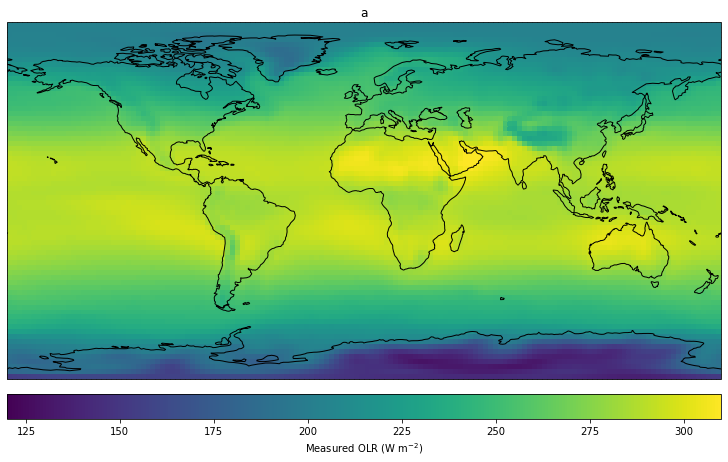

In [10]:
lon_min = min(lons)
lon_max = max(lons)
lat_min = min(lats)
lat_max = max(lats)

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=1)

maxheight = 310

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax1.coastlines()
C1 = ax1.pcolor(lons, lats, olrs, transform=ccrs.PlateCarree())
C1.set_clim(vmin=120, vmax=maxheight)
ax1.set_title("a")
fig.colorbar(
    C1,
    ax=ax1,
    label="Measured OLR (W m$^{-2}$)",
    fraction=0.3,
    orientation="horizontal",
)

path = "./Figures/"
# plt.savefig(path + 'Final Verification.png', bbox_inches='tight')

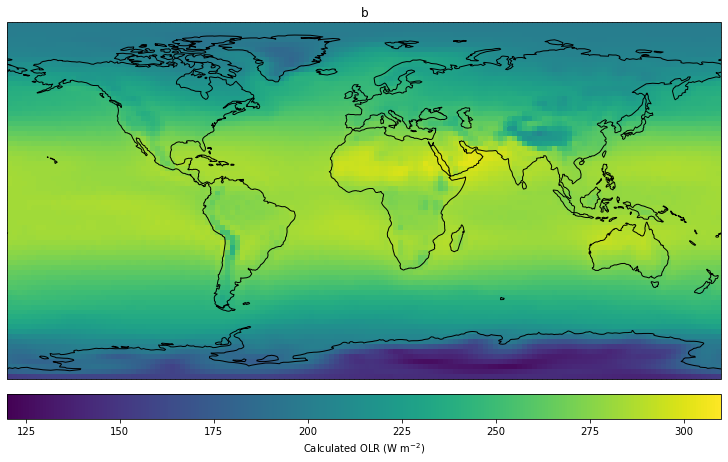

In [11]:
lon_min = min(lons)
lon_max = max(lons)
lat_min = min(lats)
lat_max = max(lats)

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=1)

maxheight = 310

ax2 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax2.coastlines()
C2 = ax2.pcolor(lons, lats, olrs_calc, transform=ccrs.PlateCarree())
C2.set_clim(vmin=120, vmax=maxheight)
ax2.set_title("b")
fig.colorbar(
    C2,
    ax=ax2,
    label="Calculated OLR (W m$^{-2}$)",
    fraction=0.3,
    orientation="horizontal",
)

path = "./Figures/"
# plt.savefig(path + 'Final Calculated Verification.png', bbox_inches='tight')

### Correlation

In [12]:
xvals = []
yvals = []
col = []

for i in range(len(lats) - 1):
    for j in range(len(lon_vals)):
        xvals.append(olrs[i, j])
        yvals.append(olrs_calc[i, j])
        col.append(lats[i])

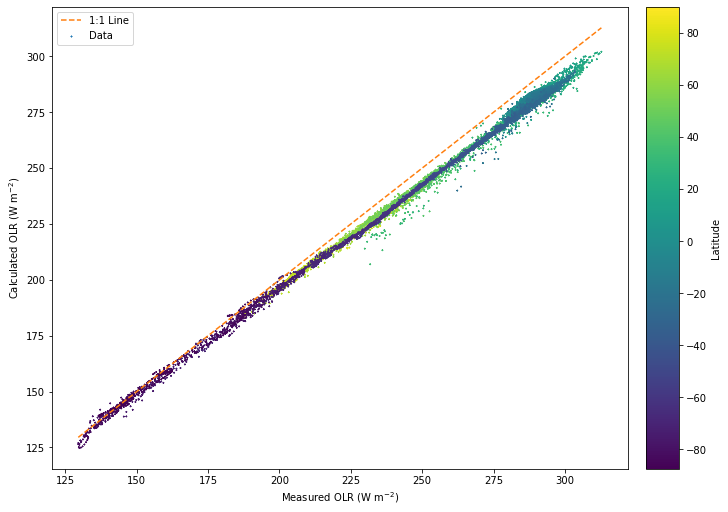

In [13]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
ax = fig.add_subplot()

plot = ax.scatter(xvals, yvals, s=1, c=col, marker="x", label="Data")
ax.plot(
    [np.amin(olrs), np.amax(olrs)],
    [np.amin(olrs), np.amax(olrs)],
    c="C1",
    label="1:1 Line",
    linestyle="--",
)
ax.set_ylabel(r"Calculated OLR (W m$^{-2}$)")
ax.set_xlabel(r"Measured OLR (W m$^{-2}$)")
fig.colorbar(plot, label="Latitude")
ax.legend()

path = "./Figures/"
# plt.savefig(path + 'Verificaion Correlation.png', bbox_inches='tight')